<font color="#483D8B">
<h1  align="center"> Distributed Deep Learning & Neural Networks</h1>
<div align="center">
<font size=3><b>
<br>Ruobing Wang
<br>April 13, 2019
<br></font></b></div>


---------------

## Overview
Objectives:
### Lab Objectives

- Execute model in a distributed, scaled out environment
- Build a hybrid LSTM pre-trained-VGG model to perform image captioning


References:

- Image captioning model with Keras (Guide 1):
    - https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

- Image captioning model with Keras (Guide 2 - Provides links to download Flickr8k dataset):
    - https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

- Useful bash commands for deep learning on AWS:
    - https://machinelearningmastery.com/command-line-recipes-deep-learning-amazon-web-services/ 




-------------

## Data

We have used the Flickr 8k dataset which contains 8000 images each with 5 captions (as we have already seen in the Introduction section that an image can have multiple captions, all being relevant simultaneously). This dataset is open source provided by the University of Illinois at Urbana-Champaign. We can down the dataset from:

- https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

We will use the “Flickr8k.token.txt” which contains the name of each image along with its 5 captions. 

And we will used the Global Vectors for Word Representation from Stanford. We can find the data from:

- https://nlp.stanford.edu/projects/glove/

The images are bifurcated as follows:

- Training Set — 6000 images
- Dev Set — 1000 images
- Test Set — 1000 images

One of the files is token which includes the name of each image along with 5 captions.

---------------


## Exploratory Data Analysis

Here are the packages we will use later:

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


From the output, we can see: 
every line contains the (image name) #i (caption), where 0≤i≤4

In [2]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "TEXT/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


And then, we create dictionary which contains the name of the image as keys and a list of the captions for the mapping image as values

In [3]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [4]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

Here we can see the output examples:

In [5]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

After we have descriptions, since we do not want the lower case count twice such as hello and Hello should be the same thing, we do not want that be regraded twice. And also, we need to remove the special tokens such as special symbols and remove the words contain numbers. Thus, we need to clean our data.

In [7]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

Now, we can see the result as following:

In [9]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

Now, we have the data after cleaning and let's create a vocabulary of all the unique words across all the image captions in the data set:

In [10]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


We can see we have 8763 unique words from all the image captions. and write them in a file with their image name.

In [11]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [12]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'TEXT/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [13]:
# Below path contains all the images
images = 'Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [14]:
# Below file conatains the names of images to be used in train data
train_images_file = 'TEXT/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

Then, load the data which contains the names of the images. 

In [15]:
# Below file conatains the names of images to be used in test data
test_images_file = 'TEXT/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [16]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


### Data Preprocessing — Images

Convert every image into a fixed size vector and input to the neural network. Utilize the InceptionV3 model. But we only need the fixed length informative vector for each image rather than classify the image. 
Hence, we just remove the last softmax layer from the model and extract a 2048 length vector. 

In [17]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [18]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 1s 0us/step


In [19]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [20]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [21]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 271.68711590766907


In [22]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [23]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 42.287375926971436


In [24]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [25]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


Then we have encoded all the test images and save in the file.

### Data Preprocessing — Captions

Captions are the stuffs we want to predict. Thus we take this as the response variables to let the model predict.

Since the images does not happen at once, we need to predict the caption word by word. So we need to encode it as the fixed sized vector.

In [26]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [27]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


Since many of these words will be rare. And we are creating a predictive model so we want the words which are common which can help us to improve our model.

In [28]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [29]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

We have 1652 unique words in the corpus and each word can be represented by integer index between 1 to 1652.

And we can get the max length of a caption from the following:

In [30]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


Now we can prepare the data by using generator function.

With SGD, we calculate the loss on a batch of data points to update the gradients and we do not need to calculate the loss on entire dataset.

In [31]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In order to map every index to a vector we have to pre-train the GLOVE Model.

In [33]:
# Load Glove vectors
glove_dir = 'glove/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [34]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [35]:
embedding_matrix.shape

(1652, 200)

---------------


## Models

Now, we have image vector and caption as our inputs. Using RNN for partial caption. We define the model as following:

In [36]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [38]:
model.layers[2]

In [39]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [41]:
epochs = 10
number_pics_per_bath = 128
steps = len(train_descriptions)//number_pics_per_bath

Using LSTM layer to precess the sequence input. 

In [43]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
46/46 [==============================] - 37s 809ms/step - loss: 4.6910
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 4.1934
Epoch 1/1
46/46 [==============================] - 37s 809ms/step - loss: 3.8929
Epoch 1/1
46/46 [==============================] - 37s 807ms/step - loss: 3.7025
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 3.5632
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 3.4558
Epoch 1/1
46/46 [==============================] - 37s 809ms/step - loss: 3.3708
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 3.2969
Epoch 1/1
46/46 [==============================] - 37s 809ms/step - loss: 3.2326
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 3.1783


In [44]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
46/46 [==============================] - 37s 810ms/step - loss: 3.1320
Epoch 1/1
46/46 [==============================] - 37s 806ms/step - loss: 3.0857
Epoch 1/1
46/46 [==============================] - 37s 807ms/step - loss: 3.0470
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 3.0135
Epoch 1/1
46/46 [==============================] - 37s 807ms/step - loss: 2.9771
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 2.9474
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 2.9184
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 2.8916
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 2.8627
Epoch 1/1
46/46 [==============================] - 37s 807ms/step - loss: 2.8399


In [47]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 128
steps = len(train_descriptions)//number_pics_per_bath

In [48]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
46/46 [==============================] - 37s 811ms/step - loss: 2.8885
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 2.8047
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 2.7744
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 2.7534
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 2.7363
Epoch 1/1
46/46 [==============================] - 37s 808ms/step - loss: 2.7226
Epoch 1/1
46/46 [==============================] - 37s 809ms/step - loss: 2.7064
Epoch 1/1
46/46 [==============================] - 37s 809ms/step - loss: 2.6952
Epoch 1/1
46/46 [==============================] - 37s 809ms/step - loss: 2.6832
Epoch 1/1
46/46 [==============================] - 37s 809ms/step - loss: 2.6723


In [49]:
model.save_weights('./model_weights/model_30.h5')

In [50]:
model.load_weights('./model_weights/model_30.h5')

In [56]:
images = 'Flicker8k_Dataset/'

In [57]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

Using Maxmum Likelihood Estimation we select the word which has the most probability. Or we can call this method Greedy Search. 

We have several iterations:

- 1:Input: Image vector + “startseq” (as partial caption) Expected Output word: “the”
- 2:Input: Image vector + “startseq the” Expected Output word: “black”
- 3:Input: Image vector + “startseq the black” Expected Output word: “cat”
......
- once we encounter 'endseq' or reach the maximum threhold of the number of words. We stop iterations.



In [58]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

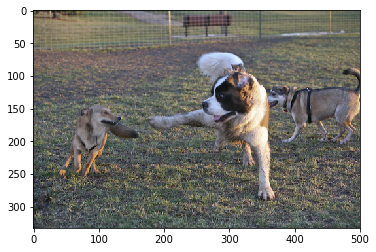

Greedy: two dogs are playing with ball in the grass


In [60]:
z=2
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

-----------------------------


## Conclusions

As the conclusion, from this lab: 

At first, we pass the sequence of the indice of partial caption and we can get index mapped to a 200 dimensional vector. And then we pass the image feature vector. Then we have 2 dropout layers in the same level which are used to avoid overfitting. Then using LSTM and dense layer. Since both the input tensors have the same shape, we merge them in a single by using tensor addition. And adding another dense layer. We have an output layer which generates the distribution across all the vocabulary we created before.

For the future work, my recommendations are:
Try a larger dataset. Adjusting the hyper parameter tunning such as learning rate or normalization and use the cross validation set to prevent overfitting. Or using another method to search, for here we used the probability distribution.

## Plot of Stage 4

```
[1,0]<stdout>:Iter #0: 51.9 img/sec per GPU
[1,0]<stdout>:Iter #1: 51.7 img/sec per GPU
[1,0]<stdout>:Iter #2: 51.6 img/sec per GPU
[1,0]<stdout>:Iter #3: 51.4 img/sec per GPU
[1,0]<stdout>:Iter #4: 51.4 img/sec per GPU
[1,0]<stdout>:Iter #5: 51.3 img/sec per GPU
[1,0]<stdout>:Iter #6: 51.2 img/sec per GPU
[1,0]<stdout>:Iter #7: 51.1 img/sec per GPU
[1,0]<stdout>:Iter #8: 51.1 img/sec per GPU
[1,0]<stdout>:Iter #9: 51.1 img/sec per GPU
[1,0]<stdout>:Img/sec per GPU: 51.4 +-0.5
[1,0]<stdout>:Total img/sec on 1 GPU(s): 51.4 +-0.5
![image.png](attachment:image.png)
```

```
[1,0]<stdout>:Iter #0: 44.7 img/sec per GPU
[1,0]<stdout>:Iter #1: 45.3 img/sec per GPU
[1,0]<stdout>:Iter #2: 45.2 img/sec per GPU
[1,0]<stdout>:Iter #3: 45.1 img/sec per GPU
[1,0]<stdout>:Iter #4: 44.9 img/sec per GPU
[1,0]<stdout>:Iter #5: 44.7 img/sec per GPU
[1,0]<stdout>:Iter #6: 43.8 img/sec per GPU
[1,0]<stdout>:Iter #7: 44.6 img/sec per GPU
[1,0]<stdout>:Iter #8: 44.4 img/sec per GPU
[1,0]<stdout>:Iter #9: 44.7 img/sec per GPU
[1,0]<stdout>:Img/sec per GPU: 44.7 +-0.8
[1,0]<stdout>:Total img/sec on 2 GPU(s): 89.5 +-1.6
![image.png](attachment:image.png)
```

```
[1,0]<stdout>:Iter #0: 32.1 img/sec per GPU
[1,0]<stdout>:Iter #1: 32.2 img/sec per GPU
[1,0]<stdout>:Iter #2: 32.1 img/sec per GPU
[1,0]<stdout>:Iter #3: 32.1 img/sec per GPU
[1,0]<stdout>:Iter #4: 32.2 img/sec per GPU
[1,0]<stdout>:Iter #5: 32.1 img/sec per GPU
[1,0]<stdout>:Iter #6: 32.1 img/sec per GPU
[1,0]<stdout>:Iter #7: 32.2 img/sec per GPU
[1,0]<stdout>:Iter #8: 32.1 img/sec per GPU
[1,0]<stdout>:Iter #9: 32.1 img/sec per GPU
[1,0]<stdout>:Img/sec per GPU: 32.1 +-0.1
[1,0]<stdout>:Total img/sec on 4 GPU(s): 128.4 +-0.4
![image.png](attachment:image.png)
```

In [1]:
import matplotlib.pyplot as plt 

No handles with labels found to put in legend.


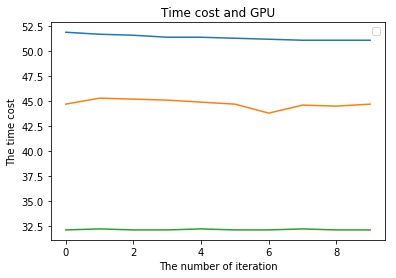

In [5]:
x = [0,1,2,3,4,5,6,7,8,9] #the number for times GPU run
y1 = [51.9, 51.7, 51.6, 51.4, 51.4, 51.3, 51.2, 51.1, 51.1, 51.1]#1 GPU
y2 = [44.7, 45.3, 45.2, 45.1, 44.9, 44.7, 43.8, 44.6, 44.5, 44.7]#2 GPU
y4 = [32.1, 32.2, 32.1, 32.1, 32.2, 32.1, 32.1, 32.2, 32.1, 32.1]#4 GPU
ls_interval_1_2 = []
ls_interval_1_4 = []
ls_interval_2_4 = []
for i in range(len(y1)):
    ls_interval_1_2.append(y1[i]-y2[i])
    ls_interval_1_4.append(y1[i]-y4[i])
    ls_interval_2_4.append(y2[i]-y4[i])
plt.xlabel('The number of iteration') 
plt.ylabel('The time cost')
plt.title('Time cost and GPU')
plt.legend()
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y4)
plt.show()


In [3]:
import numpy as np
y1 = np.array(y1)
y2 = np.array(y2)
y4 = np.array(y4)

In [4]:
y1*2>=y2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [5]:

ls_TF_1 = []
ls_TF_2 = []
ls_TF_3 = []
# We should have the differences between 2GPU and 4GPU 2 times better than 2 GPU and 1 GPU
# Compare the performance:
# can greatly simplify the code if you wrap y1,y2,y4 in np.array(). 
# ls_interval_1_2 = y1 - y2
# ls_interval_1_4 = y1 - y4
# ls_interval_1_2 >= 2*ls_interval_2_4 will return boolean no need to iterate
for i in range(len(y1)):
    if ls_interval_1_2[i] >= 3*ls_interval_1_4[i]:
        ls_TF_1.append('True')
    elif ls_interval_1_2[i] >= 2*ls_interval_2_4[i]:
        ls_TF_2.append('True')
    elif ls_interval_1_2[i] >= 2*ls_interval_2_4[i]:
        ls_TF_3.append('True')
    else:
        ls_TF_1.append('False')
        ls_TF_2.append('False')
        ls_TF_3.append('False')
print(ls_TF_1)
print(ls_TF_2)
print(ls_TF_3)

['False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False']
['False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False']
['False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False']


From the output, we can see the number of GPU increasing will have some kind of decreasing time cost but not effective. I expected the as we improve the number of GPU, we should have the time cost decreased several times. For example, 1 GPU will cost 55s, if we add 3 GPUs,   It is pretty linear in a single GPU when the GPUs are added.